## DSCI100 Project - Exploring Player Behaviors in Minecraft and their Contribution to the Game

#### Jazmine Eleanor Cabaluna | DSCI 100-003


In [6]:
#loading tidyverse, tidymodels, and repr libraries, and organizing loaded datasets
library(repr)
library(tidyverse)
library(tidymodels)
options(repr.matrix.max.rows = 10)

In [7]:
#loading and preliminary examination of provided players and sesssions dataset
players<-read_csv("players.csv")
sessions<-read_csv("sessions.csv")

Rows: 196 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, Age
lgl (1): subscribe

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 1535 Columns: 5
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (3): hashedEmail, start_time, end_time
dbl (2): original_start_time, original_end_time

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [9]:
players
# sessions

experience,subscribe,hashedEmail,played_hours,name,gender,Age
<chr>,<lgl>,<chr>,<dbl>,<chr>,<chr>,<dbl>
Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9
Veteran,TRUE,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,3.8,Christian,Male,17
Veteran,FALSE,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,0.0,Blake,Male,17
Amateur,TRUE,23fe711e0e3b77f1da7aa221ab1192afe21648d47d2b4fa7a5a659ff443a0eb5,0.7,Flora,Female,21
Regular,TRUE,7dc01f10bf20671ecfccdac23812b1b415acd42c2147cb0af4d48fcce2420f3e,0.1,Kylie,Male,21
⋮,⋮,⋮,⋮,⋮,⋮,⋮
Amateur,TRUE,b6e9e593b9ec51c5e335457341c324c34a2239531e1890b93ca52ac1dc76b08f,0.0,Bailey,Female,17
Veteran,FALSE,71453e425f07d10da4fa2b349c83e73ccdf0fb3312f778b35c5802c3292c87bd,0.3,Pascal,Male,22
Amateur,FALSE,d572f391d452b76ea2d7e5e53a3d38bfd7499c7399db299bd4fedb06a46ad5bb,0.0,Dylan,Prefer not to say,17


In [53]:
playerage<- players|>
    select(experience, played_hours, Age)|>
    arrange(-Age)|>
    mutate(log_hours=log(1+played_hours))

playerage


experience,played_hours,Age,log_hours
<chr>,<dbl>,<dbl>,<dbl>
Regular,0.0,50,0.00000000
Regular,18.5,49,2.97041447
Veteran,0.0,46,0.00000000
Amateur,0.1,45,0.09531018
Veteran,0.1,44,0.09531018
⋮,⋮,⋮,⋮
Regular,3.6,10,1.52605630
Pro,30.3,9,3.44361810
Regular,0.3,8,0.26236426


Warning message:
“Removed 2 rows containing missing values or values outside the scale range
(`geom_bar()`).”


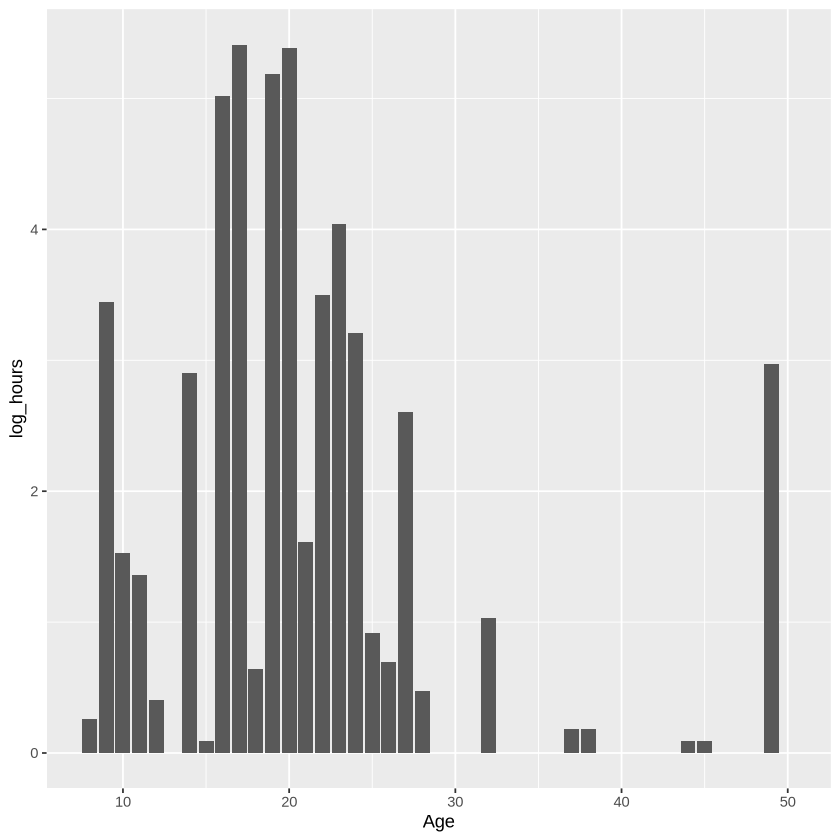

In [64]:
ageplot<-playerage|>#,fill=experience
    ggplot(aes(x=Age, y=log_hours))+
    geom_bar(stat='identity',position="dodge")

ageplot



Warning message:
“Removed 2 rows containing missing values or values outside the scale range
(`geom_point()`).”


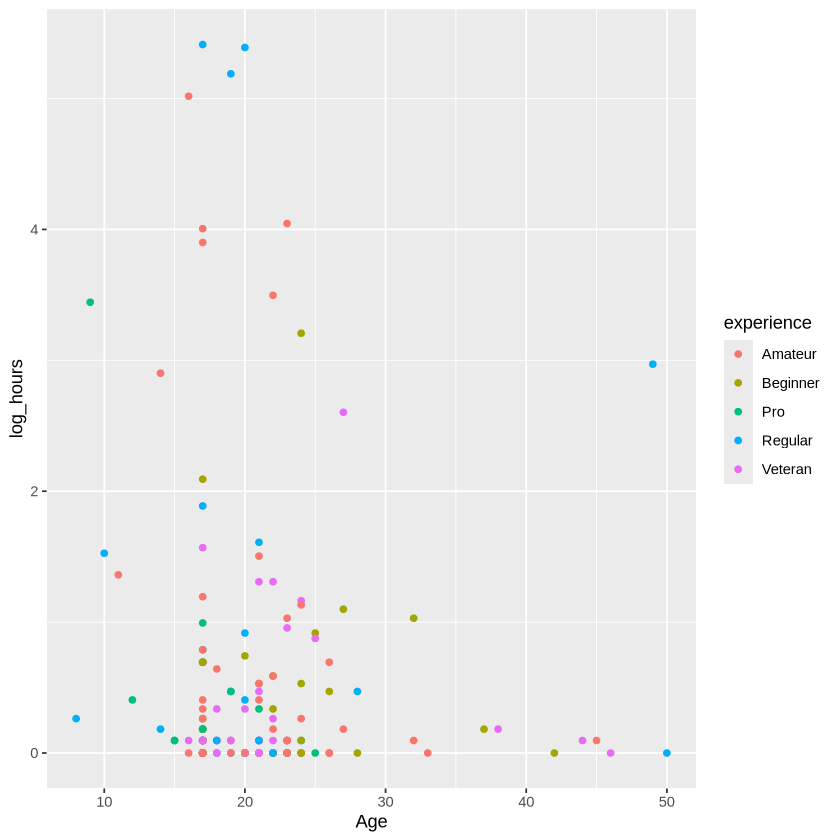

In [65]:
b<-playerage|>
    ggplot(aes(x=Age, y=log_hours, color=experience))+
    geom_point()
b